In [1]:
import sys
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

# Chapter 5 - Bayes' Rule

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()

In [3]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn

pandas    : 1.1.4
numpy     : 1.19.3
pymc3     : 3.10.0
matplotlib: 3.3.0
seaborn   : 0.11.0



## 5.3. Complete Examples: Estimating Bias in Coins

In [85]:
def normalize(a):
    return a / a.sum()

In [86]:
theta_grid = np.linspace(0, 1, 11)
prior = normalize(np.array([0, .1, .2, .3, .4, .5, .4, .3, .2, .1, 0]))

In [87]:
theta_grid

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [88]:
prior

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.16, 0.12, 0.08, 0.04, 0.  ])

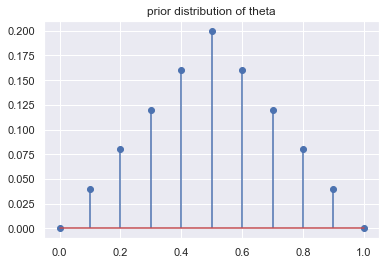

In [89]:
plt.stem(theta_grid, prior)
plt.title('prior distribution of theta');

In [90]:
def bernoulli(y1, th):  # Bernoulli distr.
    return th if y1 else 1-th

def likelihood(y, th):  # p(y|th), 
    r = [bernoulli(yi, th) for yi in y]
    return np.prod(r)

In [91]:
likelihood([0, 0], .2)

0.6400000000000001

In [92]:
y = [1]
likeli = normalize(np.array([likelihood(y, th) for th in theta_grid]))
likeli

array([0.        , 0.01818182, 0.03636364, 0.05454545, 0.07272727,
       0.09090909, 0.10909091, 0.12727273, 0.14545455, 0.16363636,
       0.18181818])

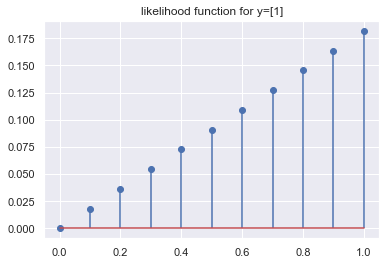

In [93]:
plt.stem(theta_grid, likeli);
plt.title(f'likelihood function for y={y}');

In [94]:
posterior = normalize(likeli * prior)

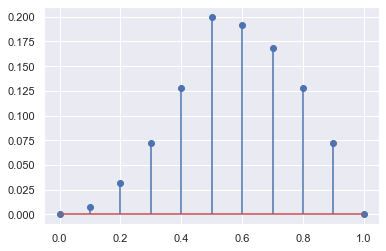

In [95]:
plt.stem(theta_grid, posterior);

### 5.3.1. Influence of sample size on the posterior
- The more data we have the more precise is the estimate of the parameters in the model.

In [156]:
Ns = [[1,4], [10, 40], [100, 400]]
theta_grid = np.linspace(0,1, 1001)

In [157]:
def triangle(x):
    ihalf = len(x) // 2
    m = 1. / x[ihalf]
    p = np.zeros_like(x)
    for i in range(len(x)):
        if i <= ihalf:
            p[i] = x[i] * m  # linear eq.
        else:
            p[i] = p[ihalf - (i - ihalf - 1)]
    return normalize(p)  # normalize to have sum 1
prior = triangle(theta_grid)

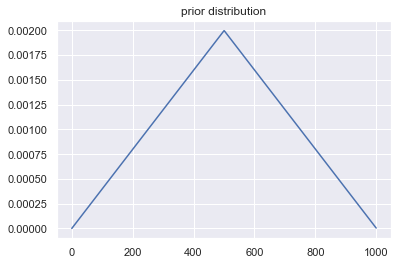

In [158]:
plt.plot(prior);
plt.title('prior distribution');

In [159]:
def get_y(Npair):  # Npair = (k, N)
    k, N = Npair
    y = np.zeros(N)
    y[:k] = 1
    return y

In [160]:
ys = [ get_y(Np) for Np in Ns ]
ys

[array([1., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

In [161]:
def get_likelihood(y, th_grid):
    return normalize(np.array([likelihood(y, th) for th in th_grid]))
    
likelis = [get_likelihood(y, theta_grid) for y in ys]

In [162]:
likelis

[array([0.00000000e+00, 1.99400932e-05, 3.97605459e-05, ...,
        1.59680266e-10, 1.99800333e-11, 0.00000000e+00]),
 array([0.00000000e+00, 3.37264371e-23, 3.35136718e-20, ...,
        3.65772541e-74, 3.44081006e-83, 0.00000000e+00]),
 array([0.00000000e+000, 6.65883601e-205, 6.25048625e-175, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000])]

In [163]:
posteriors = [ normalize(likeli * prior) for likeli in likelis ]

In [164]:
def get_mode(f, x):  # use np.argsort()
    fx = np.array([f, x])  # 2xN array
    arg = fx[0,:].argsort()[::-1]
    mode_loc = arg[0]
    return x[mode_loc]

In [165]:
def get_hdi(f, x):  # use np.argsort()
    """ assumes that f is a uni-modal function of x """
    fx = np.array([f, x])  # 2xN array
    arg = fx[0,:].argsort()[::-1]
    psum = 0
    i = 0
    ims = []
    while psum < .95:
        psum += f[arg[i]]
        i += 1
        ims.append(arg[i])
    return np.array([ fx[:, min(ims)], fx[:, max(ims)] ])

In [166]:
get_mode(prior, theta_grid)

0.5

In [167]:
get_hdi(prior, theta_grid)

array([[4.43113772e-04, 1.11000000e-01],
       [4.47105788e-04, 8.89000000e-01]])

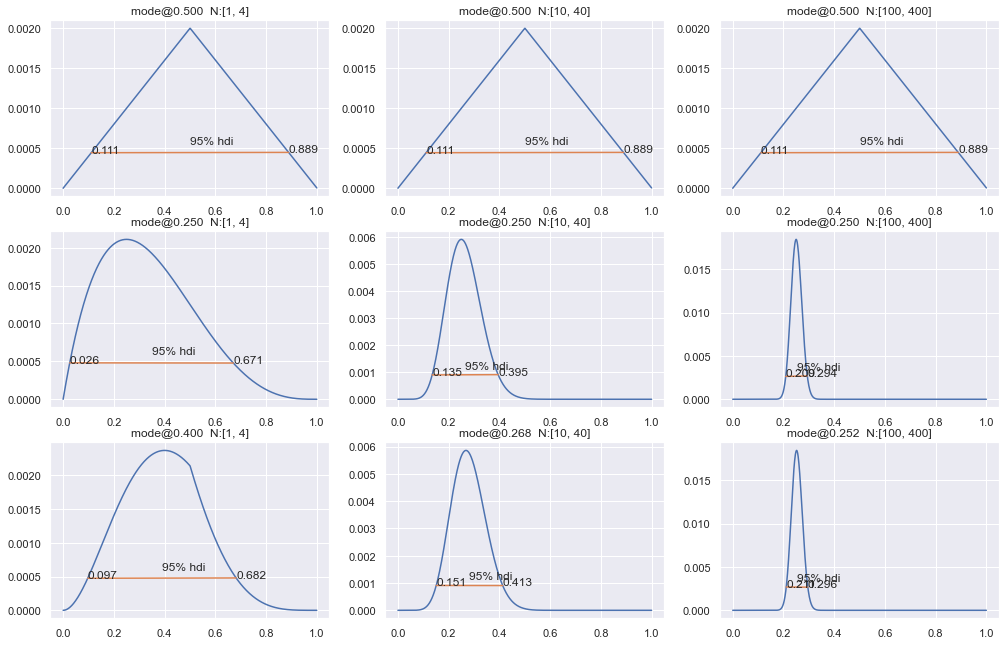

In [168]:
def plot_hdi(hdi, ax):
    ax.plot(hdi[:,1], hdi[:,0], '-')
    fx = hdi.mean(axis=0)
    ax.text(fx[1], fx[0]*1.25, '95% hdi')
    for i in range(2):
        ax.text(hdi[i,1], hdi[i,0], f'{hdi[i,1]:.3f}')
            
fig, axes = plt.subplots(3, 3, figsize=(17,11))
for i in range(len(Ns)):
    Np = Ns[i]
    items = [prior, likelis[i], posteriors[i]]
    for j in range(3):
        ax = axes[j,i]
        ax.plot(theta_grid, items[j])
        ax.set_title(f'mode@{get_mode(items[j], theta_grid):.3f}  N:{Ns[i]}')
        plot_hdi(get_hdi(items[j], theta_grid), ax)